In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext tensorboard

# load tensorflow dependencies
import tensorflow as tf

# 16 bit precision computing
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.layers import Cropping2D
print(tf.__version__)
print(tf.config.experimental.list_physical_devices())

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import skimage.io
import sys


from sklearn.model_selection import StratifiedKFold
import time

sys.path.insert(0,'..')

# custom packages
from preprocessing.utils.data_loader import PandasDataLoader
from preprocessing.generators import TiffGenerator, TiffFromCoords, UNETGenerator
from preprocessing.utils.mat_transforms import tf_tile2mat, tf_tile2square
from utils.utils import set_gpu_memory, seed_all

from preprocessing.utils.data_loader import PandasDataLoader
from model.unet.unet_tfkeras import unet
from model.layers import WeightLayer
from tensorflow.keras.models import Model


2.2.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
seed_all(20)
DATA_DIR = Path('../data/')

# control for the gpu memory, and number of used gpu's
set_gpu_memory(device_type='GPU')
# see the utils functions which seeds are set
# tensorflow ops still have to be seeded manually...
seed_all()

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

1 Physical GPUs, 1 Logical GPUs
Compute dtype: float16
Variable dtype: float32


## Initialization

In [4]:
# ------------------
# Directories
# ------------------
DATA_DIR = '../data'  # General path to the data dir
IMG_DIR = '../data/train_images'  # Path to the TILED images
TRAIN_MASKS_DIR = '../data/train_label_masks'  # Path to the masks
TIFF_LEVEL = 1

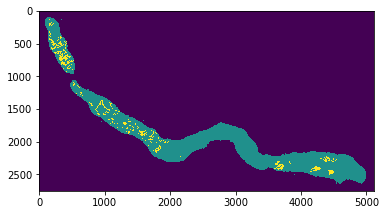

In [5]:
mask_paths = Path(TRAIN_MASKS_DIR).rglob('*.tiff')
mask_paths = list(mask_paths)
mask = skimage.io.MultiImage(str(mask_paths[50]))[1]
plt.imshow(mask[:,:,0])

In [6]:
from tqdm import tqdm
from preprocessing.utils.tiling import get_tile_coords

In [ ]:
DATA_DIR = list(Path('../data/train_images').glob('*.tiff'))
data_list = [str(x) for x in DATA_DIR]
# generate inference 
inference_generator = UNETGenerator(data_list, mode='inference')
inference_generator = inference_generator.load_process()


unet = unet()
weight_layer = WeightLayer()(unet.outputs)
model = Model(inputs=unet.inputs, outputs=weight_layer)

level = 2
sz = 60
N = 36
pad_val = 1
all_coords = []
for i,x in enumerate(tqdm(inference_generator)):
    crops = tf.squeeze(x[1])
    preds = model.predict(x[0])
    result = UNETGenerator.crop(preds, crops)
    img_id = x[2].numpy()[0].decode('utf8').split('/')[-1].split('.')[0]
    
    coords = get_tile_coords(preds[0,...], sz, N, pad_val)
    all_coords.append(np.array([img_id, coords]))
    print("img id in gen", img_id)
    print("path in gen", x[2])
    print(x[0].shape)
    print(coords)

1it [00:04,  4.87s/it]

img id in gen 0005f7aaab2800f6170c399693a96917
path in gen tf.Tensor([b'../data/train_images/0005f7aaab2800f6170c399693a96917.tiff'], shape=(1,), dtype=string)
(1, 2048, 1792, 3)
[[1080  480]
 [1560  240]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  240]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 840  240]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [1560  480]
 [1560  720]]


2it [00:06,  3.79s/it]

img id in gen 000920ad0b612851f8e01bcc880d9b3d
path in gen tf.Tensor([b'../data/train_images/000920ad0b612851f8e01bcc880d9b3d.tiff'], shape=(1,), dtype=string)
(1, 1024, 1024, 3)
[[240 960]
 [480 960]
 [720 960]
 [120 960]
 [360 960]
 [600 960]
 [840 960]
 [ 60 960]
 [180 960]
 [300 960]
 [420 960]
 [540 960]
 [660 960]
 [780 960]
 [900 960]
 [960 960]
 [120 240]
 [120 480]
 [120 720]
 [360 240]
 [360 480]
 [600 240]
 [600 720]
 [840 240]
 [840 480]
 [840 720]
 [300 840]
 [120 120]
 [120 360]
 [120 600]
 [360 120]
 [360 360]
 [360 600]
 [360 840]
 [600 120]
 [600 360]]


3it [00:07,  3.03s/it]

img id in gen 0018ae58b01bdadc8e347995b69f99aa
path in gen tf.Tensor([b'../data/train_images/0018ae58b01bdadc8e347995b69f99aa.tiff'], shape=(1,), dtype=string)
(1, 1792, 512, 3)
[[ 360  240]
 [ 600  240]
 [ 120  360]
 [ 360  360]
 [ 600  360]
 [ 840  360]
 [1080  360]
 [1320  360]
 [1440  360]
 [1560  120]
 [1560  360]
 [ 240  240]
 [ 480  240]
 [  60  240]
 [ 120  240]
 [ 300  240]
 [ 540  240]
 [ 240  360]
 [ 480  360]
 [ 720  360]
 [ 960  360]
 [1200  360]
 [1440  120]
 [1560  300]
 [ 120  300]
 [ 360  300]
 [ 600  300]
 [ 840  300]
 [1320   60]
 [1560   60]
 [1680  240]
 [1200    0]
 [1380  360]
 [1440    0]
 [ 180  240]
 [ 240  300]]


4it [00:09,  2.70s/it]

img id in gen 001c62abd11fa4b57bf7a6c603a11bb9
path in gen tf.Tensor([b'../data/train_images/001c62abd11fa4b57bf7a6c603a11bb9.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[1560  840]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  240]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  960]
 [1560 1200]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 120 1320]]


5it [00:11,  2.67s/it]

img id in gen 001d865e65ef5d2579c190a0e0350d8f
path in gen tf.Tensor([b'../data/train_images/001d865e65ef5d2579c190a0e0350d8f.tiff'], shape=(1,), dtype=string)
(1, 2304, 1792, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080 1200]
 [1320  240]
 [1320  720]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560 1200]
 [1800  240]
 [1800  480]
 [1800  720]
 [1800 1200]]


6it [00:14,  2.52s/it]

img id in gen 002a4db09dad406c85505a00fb6f6144
path in gen tf.Tensor([b'../data/train_images/002a4db09dad406c85505a00fb6f6144.tiff'], shape=(1,), dtype=string)
(1, 2048, 1536, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360 1200]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [1800  240]
 [1800  480]
 [1800  720]]


7it [00:16,  2.53s/it]

img id in gen 003046e27c8ead3e3db155780dc5498e
path in gen tf.Tensor([b'../data/train_images/003046e27c8ead3e3db155780dc5498e.tiff'], shape=(1,), dtype=string)
(1, 2304, 1536, 3)
[[ 360  960]
 [ 480  960]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360 1200]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1800  240]
 [1800  480]
 [1800  720]
 [1800  960]
 [2040  240]]


8it [00:16,  1.85s/it]

img id in gen 0032bfa835ce0f43a92ae0bbab6871cb
path in gen tf.Tensor([b'../data/train_images/0032bfa835ce0f43a92ae0bbab6871cb.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[ 600  480]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  240]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [ 480  600]
 [ 120  120]
 [ 120  360]
 [ 120  600]]


9it [00:18,  1.66s/it]

img id in gen 003a91841da04a5a31f808fb5c21538a
path in gen tf.Tensor([b'../data/train_images/003a91841da04a5a31f808fb5c21538a.tiff'], shape=(1,), dtype=string)
(1, 768, 1024, 3)
[[240 960]
 [480 960]
 [120 960]
 [360 960]
 [600 960]
 [ 60 960]
 [660 960]
 [180 960]
 [300 960]
 [420 960]
 [540 960]
 [120 240]
 [120 480]
 [120 720]
 [360 720]
 [600 240]
 [600 480]
 [600 720]
 [360 480]
 [480 360]
 [120 120]
 [120 360]
 [120 600]
 [120 840]
 [360 120]
 [360 600]
 [360 840]
 [600 120]
 [600 360]
 [600 600]
 [600 840]
 [240 480]
 [240 720]
 [480 240]
 [480 720]
 [ 60 240]]


10it [00:20,  1.82s/it]

img id in gen 003d4dd6bd61221ebc0bfb9350db333f
path in gen tf.Tensor([b'../data/train_images/003d4dd6bd61221ebc0bfb9350db333f.tiff'], shape=(1,), dtype=string)
(1, 1536, 2048, 3)
[[ 240 1980]
 [ 360  960]
 [ 480 1980]
 [ 720 1980]
 [ 960 1980]
 [1200 1980]
 [1440 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [1080 1560]
 [1080 1980]
 [1320 1980]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1440]
 [ 120 1680]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360 1440]
 [ 360 1680]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 600 1440]
 [ 600 1680]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840 1200]
 [ 840 1440]]


11it [00:21,  1.70s/it]

img id in gen 00412139e6b04d1e1cee8421f38f6e90
path in gen tf.Tensor([b'../data/train_images/00412139e6b04d1e1cee8421f38f6e90.tiff'], shape=(1,), dtype=string)
(1, 1280, 1024, 3)
[[1200  960]
 [ 240  960]
 [ 480  960]
 [ 720  960]
 [ 960  960]
 [ 120  960]
 [ 360  960]
 [ 600  960]
 [ 840  960]
 [1080  960]
 [  60  960]
 [ 180  960]
 [ 300  960]
 [ 420  960]
 [ 540  960]
 [ 660  960]
 [ 780  960]
 [ 900  960]
 [1020  960]
 [1140  960]
 [ 120  240]
 [ 120  720]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 480  240]
 [ 600  480]
 [ 600  720]
 [ 840  480]
 [ 840  720]
 [1080  480]
 [1080  720]
 [ 120  120]
 [ 120  480]
 [ 120  600]
 [ 120  840]]


12it [00:24,  2.00s/it]

img id in gen 004391d48d58b18156f811087cd38abf
path in gen tf.Tensor([b'../data/train_images/004391d48d58b18156f811087cd38abf.tiff'], shape=(1,), dtype=string)
(1, 2048, 2048, 3)
[[ 240 1980]
 [ 480 1980]
 [ 720 1980]
 [ 960 1980]
 [1200 1980]
 [1440 1980]
 [1680 1980]
 [1920 1980]
 [1980 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [1080 1980]
 [1320 1980]
 [1560 1980]
 [1800 1980]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1680]
 [ 300 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1440]
 [ 360 1680]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 600 1440]
 [ 600 1680]]


13it [00:25,  1.76s/it]

img id in gen 004dd32d9cd167d9cc31c13b704498af
path in gen tf.Tensor([b'../data/train_images/004dd32d9cd167d9cc31c13b704498af.tiff'], shape=(1,), dtype=string)
(1, 1536, 512, 3)
[[ 120  240]
 [ 360  240]
 [1080  240]
 [1320  240]
 [ 120  360]
 [ 360  360]
 [ 600  360]
 [ 840  120]
 [1080  120]
 [1320  120]
 [ 240  240]
 [ 960  240]
 [1200  240]
 [ 480  240]
 [  60  240]
 [ 300  240]
 [1020  240]
 [1260  240]
 [ 240  360]
 [ 480  360]
 [ 720  120]
 [ 960  120]
 [1200  120]
 [ 120  300]
 [ 360  300]
 [ 840   60]
 [1080   60]
 [1320   60]
 [ 120  180]
 [ 360  180]
 [ 720    0]
 [ 840  180]
 [ 960    0]
 [1080  180]
 [1200    0]
 [1320  180]]


14it [00:27,  1.80s/it]

img id in gen 004f6b3a66189b4e88b6a01ba19d7d31
path in gen tf.Tensor([b'../data/train_images/004f6b3a66189b4e88b6a01ba19d7d31.tiff'], shape=(1,), dtype=string)
(1, 2048, 1280, 3)
[[ 120  240]
 [ 120  720]
 [ 120  960]
 [ 240 1200]
 [ 360  240]
 [ 360  960]
 [ 480 1200]
 [ 600  240]
 [ 600  960]
 [ 720 1200]
 [ 840  960]
 [ 960 1200]
 [1080  240]
 [1080  960]
 [1200 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1440 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1680 1200]
 [1800  240]
 [1800  480]
 [1800  720]
 [1800  960]
 [1920 1200]
 [ 600  720]
 [1980 1200]
 [ 120 1200]
 [ 360 1200]
 [ 600  360]
 [ 600 1200]]


15it [00:30,  2.17s/it]

img id in gen 005e66f06bce9c2e49142536caf2f6ee
path in gen tf.Tensor([b'../data/train_images/005e66f06bce9c2e49142536caf2f6ee.tiff'], shape=(1,), dtype=string)
(1, 2560, 2048, 3)
[[1320  960]
 [ 240 1980]
 [ 480 1980]
 [ 720 1980]
 [ 960 1980]
 [1200 1980]
 [1440 1980]
 [1680 1980]
 [1920 1980]
 [2160 1980]
 [2400 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [1080 1980]
 [1320 1980]
 [1560 1980]
 [1800 1980]
 [2040 1980]
 [2280 1980]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1800]
 [ 600  240]
 [ 600  480]
 [ 600  720]]


16it [00:31,  1.86s/it]

img id in gen 0068d4c7529e34fd4c9da863ce01a161
path in gen tf.Tensor([b'../data/train_images/0068d4c7529e34fd4c9da863ce01a161.tiff'], shape=(1,), dtype=string)
(1, 768, 512, 3)
[[600 240]
 [120 360]
 [600 120]
 [600 360]
 [240 360]
 [120 300]
 [600  60]
 [600 180]
 [600 300]
 [480   0]
 [360   0]
 [480  60]
 [600   0]
 [ 60 360]
 [240 420]
 [360 420]
 [540 120]
 [600 420]
 [ 60 300]
 [180 360]
 [540   0]
 [540  60]
 [120 420]
 [420   0]
 [480 420]
 [660   0]
 [660 240]
 [300   0]
 [ 60 420]
 [540 420]
 [660 120]
 [660 360]
 [300 420]
 [ 60 240]
 [420  60]
 [660  60]]


17it [00:33,  1.88s/it]

img id in gen 006f4d8d3556dd21f6424202c2d294a9
path in gen tf.Tensor([b'../data/train_images/006f4d8d3556dd21f6424202c2d294a9.tiff'], shape=(1,), dtype=string)
(1, 1536, 1792, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120  840]]


18it [00:34,  1.59s/it]

img id in gen 006f6aa35a78965c92fffd1fbd53a058
path in gen tf.Tensor([b'../data/train_images/006f6aa35a78965c92fffd1fbd53a058.tiff'], shape=(1,), dtype=string)
(1, 512, 256, 3)
[[240 180]
 [120 180]
 [360 180]
 [360 120]
 [ 60 180]
 [240 120]
 [120 120]
 [300 180]
 [420 180]
 [ 60 120]
 [180 180]
 [300 120]
 [180 120]
 [420 120]
 [420  60]
 [  0 180]
 [  0 120]
 [360  60]
 [180   0]
 [420   0]
 [ 60  60]
 [  0  60]
 [240   0]
 [ 60   0]
 [300  60]
 [120   0]
 [120  60]
 [  0   0]
 [240  60]
 [180  60]
 [300   0]
 [360   0]
 [480 180]
 [480 120]
 [480  60]
 [480   0]]


19it [00:35,  1.52s/it]

img id in gen 007433133235efc27a39f11df6940829
path in gen tf.Tensor([b'../data/train_images/007433133235efc27a39f11df6940829.tiff'], shape=(1,), dtype=string)
(1, 1536, 768, 3)
[[ 120  240]
 [ 120  480]
 [ 360  480]
 [ 600  480]
 [ 840  480]
 [1320  240]
 [1320  480]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 360  600]
 [ 600  600]
 [ 840  600]
 [1080  600]
 [1320  120]
 [1320  360]
 [1320  600]
 [ 240  480]
 [ 480  480]
 [ 720  480]
 [1080  120]
 [1200  240]
 [1200  360]
 [  60  240]
 [  60  480]
 [ 300  480]
 [ 540  480]
 [ 780  480]
 [1260  240]
 [1260  480]
 [ 240  600]
 [ 480  600]
 [ 720  600]
 [ 960  600]
 [1200  120]
 [1200  600]]


20it [00:37,  1.42s/it]

img id in gen 0076bcb66e46fb485f5ba432b9a1fe8a
path in gen tf.Tensor([b'../data/train_images/0076bcb66e46fb485f5ba432b9a1fe8a.tiff'], shape=(1,), dtype=string)
(1, 1024, 768, 3)
[[840 240]
 [120 600]
 [840 120]
 [600 120]
 [720 120]
 [120 540]
 [600  60]
 [840  60]
 [840 300]
 [480   0]
 [720   0]
 [840 180]
 [360   0]
 [480  60]
 [600   0]
 [720  60]
 [840   0]
 [ 60 480]
 [ 60 600]
 [780 120]
 [ 60 540]
 [180 600]
 [240   0]
 [240 600]
 [300   0]
 [540   0]
 [540  60]
 [660 120]
 [720 180]
 [780   0]
 [780  60]
 [900 240]
 [420   0]
 [660   0]
 [900   0]
 [900 480]]


21it [00:38,  1.40s/it]

img id in gen 008069b542b0439ed69b194674051964
path in gen tf.Tensor([b'../data/train_images/008069b542b0439ed69b194674051964.tiff'], shape=(1,), dtype=string)
(1, 768, 1536, 3)
[[ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 120  120]
 [ 360  360]
 [ 360  600]
 [ 360  840]
 [ 360 1080]
 [ 360 1320]
 [ 600  120]
 [ 600  360]
 [ 600  600]
 [ 600  840]
 [ 600 1080]
 [ 600 1320]
 [ 240  720]
 [ 240  960]
 [ 240 1200]
 [ 480  240]
 [ 480  480]
 [ 480  720]
 [ 480  960]
 [ 480 1200]
 [ 240 1440]
 [ 360 1440]
 [ 480 1440]
 [ 600 1440]
 [  60  240]
 [ 300  480]
 [ 300  720]]


22it [00:40,  1.54s/it]

img id in gen 008308f099f0c565fbc024ece6b8b08c
path in gen tf.Tensor([b'../data/train_images/008308f099f0c565fbc024ece6b8b08c.tiff'], shape=(1,), dtype=string)
(1, 1792, 1280, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 240 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 480 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 720 1200]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 960 1200]
 [1080  480]
 [1080  720]
 [1080  960]
 [1200 1200]
 [1320  480]
 [1320  720]
 [1320  960]
 [1440 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1680 1200]
 [1320  240]
 [ 120 1200]
 [ 360 1200]
 [ 600 1200]
 [ 840 1200]
 [1080 1200]]


23it [00:41,  1.55s/it]

img id in gen 00928370e2dfeb8a507667ef1d4efcbb
path in gen tf.Tensor([b'../data/train_images/00928370e2dfeb8a507667ef1d4efcbb.tiff'], shape=(1,), dtype=string)
(1, 2304, 768, 3)
[[ 600  480]
 [ 840  480]
 [1080  480]
 [1560  240]
 [1800  240]
 [2040  480]
 [ 120  120]
 [ 360  120]
 [ 360  600]
 [ 600  120]
 [ 600  600]
 [ 840  120]
 [ 840  600]
 [1080  120]
 [1080  600]
 [1320  120]
 [1320  600]
 [1560  120]
 [1560  600]
 [1800  120]
 [1800  600]
 [2040  600]
 [ 720  480]
 [ 960  480]
 [1200  480]
 [1680  240]
 [2160  480]
 [ 240  600]
 [ 780  480]
 [1020  480]
 [1260  480]
 [1740  240]
 [ 240  120]
 [ 480  120]
 [ 480  600]
 [ 720  120]]


24it [00:42,  1.42s/it]

img id in gen 00951a7fad040bf7e90f32e81fc0746f
path in gen tf.Tensor([b'../data/train_images/00951a7fad040bf7e90f32e81fc0746f.tiff'], shape=(1,), dtype=string)
(1, 512, 768, 3)
[[360  60]
 [360   0]
 [ 60 600]
 [120 660]
 [240 660]
 [360 660]
 [360 120]
 [420   0]
 [ 60   0]
 [300 660]
 [ 60 660]
 [180 660]
 [300   0]
 [420  60]
 [420 120]
 [120 600]
 [240   0]
 [420 660]
 [ 60 540]
 [120   0]
 [180   0]
 [  0   0]
 [  0 480]
 [300  60]
 [  0 600]
 [420 180]
 [  0 540]
 [  0 660]
 [  0  60]
 [240  60]
 [420 240]
 [ 60 480]
 [360 180]
 [  0 420]
 [420 600]
 [ 60  60]]


26it [00:44,  1.12s/it]

img id in gen 00a26aaa82c959624d90dfb69fcf259c
path in gen tf.Tensor([b'../data/train_images/00a26aaa82c959624d90dfb69fcf259c.tiff'], shape=(1,), dtype=string)
(1, 1536, 1280, 3)
[[1200 1200]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 240 1200]
 [ 360  720]
 [ 360  960]
 [ 480 1200]
 [ 600  240]
 [ 600  720]
 [ 600  960]
 [ 720 1200]
 [ 840  240]
 [ 840  960]
 [ 960 1200]
 [1080  240]
 [1080  480]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [ 120 1200]
 [ 360 1200]
 [ 600 1200]
 [ 840 1200]
 [1080 1200]
 [1440 1200]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 360  120]
 [ 360  600]
 [ 360  840]
 [ 360 1080]]
img id in gen 00a76bfbec239fd9f465d6581806ff42
path in gen tf.Tensor([b'../data/train_images/00a76bfbec239fd9f465d6581806ff42.tiff'], shape=(1,), dtype=string)
(1, 1024, 1024, 3)
[[240 960]
 [480 960]
 [720 960]
 [120 960]
 [360 960]
 [600 960]
 [840 960]
 [ 60 960]
 [180 960]
 [300 960]
 [420 960]
 [540 960]
 [660 960]
 [780 960]
 [900 960]
 [960 96

27it [00:46,  1.17s/it]

img id in gen 00a7fb880dc12c5de82df39b30533da9
path in gen tf.Tensor([b'../data/train_images/00a7fb880dc12c5de82df39b30533da9.tiff'], shape=(1,), dtype=string)
(1, 512, 2048, 3)
[[ 240 1980]
 [ 120 1980]
 [ 360 1980]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 360 1680]
 [  60 1980]
 [ 120 1920]
 [ 240  240]
 [ 360  120]
 [ 360  360]
 [ 360  600]
 [ 360  840]
 [ 360 1080]
 [ 360 1320]
 [ 360 1560]
 [ 360 1800]
 [ 180 1980]
 [ 240  480]
 [ 240  720]
 [ 240  960]
 [ 240 1200]
 [ 240 1440]
 [ 240 1680]
 [ 360 1920]
 [ 180 1680]
 [ 240  600]
 [ 240  120]
 [ 300  240]
 [ 300  480]
 [ 300  720]
 [ 300  960]]


28it [00:48,  1.53s/it]

img id in gen 00a97615a51ba4c475bdec8505623bf9
path in gen tf.Tensor([b'../data/train_images/00a97615a51ba4c475bdec8505623bf9.tiff'], shape=(1,), dtype=string)
(1, 1536, 2304, 3)
[[ 360 1200]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 120 1680]
 [ 120 1920]
 [ 120 2160]
 [ 360  240]
 [ 360 1440]
 [ 360 1680]
 [ 360 1920]
 [ 360 2160]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 600 1680]
 [ 600 1920]
 [ 600 2160]
 [ 840  240]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [ 840 1680]
 [ 840 1920]
 [ 840 2160]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080 1200]
 [1080 1440]]


29it [00:48,  1.11s/it]

img id in gen 00bbc1482301d16de3ff63238cfd0b34
path in gen tf.Tensor([b'../data/train_images/00bbc1482301d16de3ff63238cfd0b34.tiff'], shape=(1,), dtype=string)
(1, 1792, 512, 3)
[[ 600  240]
 [ 840  240]
 [1080  240]
 [1320  240]
 [ 120  360]
 [ 360  360]
 [ 600  360]
 [ 840  360]
 [1080  360]
 [1320  360]
 [1560  360]
 [ 720  240]
 [ 960  240]
 [1200  240]
 [ 540  240]
 [ 780  240]
 [1020  240]
 [1260  240]
 [ 240  360]
 [ 480  360]
 [ 720  360]
 [ 960  360]
 [1200  360]
 [1440  360]
 [ 120   60]
 [ 120  300]
 [ 360  300]
 [ 600  300]
 [ 840  300]
 [1080  300]
 [1320  300]
 [1560   60]
 [1680  240]
 [ 960  120]
 [ 240    0]
 [ 480    0]]


30it [00:48,  1.21it/s]

img id in gen 00c15b23b30a5ba061358d9641118904
path in gen tf.Tensor([b'../data/train_images/00c15b23b30a5ba061358d9641118904.tiff'], shape=(1,), dtype=string)
(1, 2304, 768, 3)
[[ 120  480]
 [ 360  480]
 [ 600  480]
 [ 840  480]
 [1080  480]
 [1320  480]
 [1560  480]
 [ 120  360]
 [ 120  600]
 [ 360  600]
 [ 600  600]
 [ 840  600]
 [1080  120]
 [1080  600]
 [1320  120]
 [1320  600]
 [1560  120]
 [1560  600]
 [1800  120]
 [1800  600]
 [2040  120]
 [2040  600]
 [ 240  480]
 [ 480  480]
 [ 720  480]
 [ 960  480]
 [1200  480]
 [1440  480]
 [2160  240]
 [  60  480]
 [ 300  480]
 [ 540  480]
 [ 780  480]
 [1020  480]
 [1260  480]
 [1500  480]]


32it [00:50,  1.48it/s]

img id in gen 00c46b336b5b06423fcdec1b4d5bee06
path in gen tf.Tensor([b'../data/train_images/00c46b336b5b06423fcdec1b4d5bee06.tiff'], shape=(1,), dtype=string)
(1, 2048, 256, 3)
[[ 480  180]
 [1920  180]
 [ 720  180]
 [1560  180]
 [1680  180]
 [1800  180]
 [1980  180]
 [ 360  180]
 [ 240  180]
 [ 300  180]
 [ 600  180]
 [1500  180]
 [ 540  180]
 [1620  180]
 [1740  180]
 [ 420  180]
 [ 660  180]
 [1860  180]
 [ 960    0]
 [1200    0]
 [ 120    0]
 [1080    0]
 [1320    0]
 [1440    0]
 [1500    0]
 [1980  120]
 [  60    0]
 [1020    0]
 [1200   60]
 [1260    0]
 [1440  180]
 [1980   60]
 [ 180    0]
 [1140    0]
 [1380    0]
 [1980    0]]
img id in gen 00c52cb4db1c7a5811a8f070a910c038
path in gen tf.Tensor([b'../data/train_images/00c52cb4db1c7a5811a8f070a910c038.tiff'], shape=(1,), dtype=string)
(1, 1536, 768, 3)
[[ 120  240]
 [ 360  240]
 [ 840  480]
 [1080  480]
 [1320  240]
 [1320  480]
 [ 120  120]
 [ 120  600]
 [ 360  120]
 [ 360  600]
 [ 600  120]
 [ 600  600]
 [ 840  600]
 [1080

33it [00:51,  1.13it/s]

img id in gen 00ca0c23961b5510be46c917be11c43e
path in gen tf.Tensor([b'../data/train_images/00ca0c23961b5510be46c917be11c43e.tiff'], shape=(1,), dtype=string)
(1, 2560, 512, 3)
[[ 120  360]
 [ 600  360]
 [ 840  360]
 [1080  360]
 [1320  360]
 [1560  360]
 [1800  360]
 [2040  360]
 [2280  360]
 [2400  240]
 [ 360  360]
 [ 240  360]
 [ 720  360]
 [ 960  360]
 [1200  360]
 [1440  360]
 [1680  360]
 [1920  360]
 [2160  360]
 [2400  120]
 [2400  360]
 [ 120   60]
 [ 480  360]
 [1080  300]
 [1320  300]
 [1800   60]
 [2040   60]
 [ 240    0]
 [ 480    0]
 [ 720    0]
 [ 960    0]
 [1200    0]
 [1440    0]
 [1680    0]
 [1920    0]
 [2400    0]]


35it [00:51,  1.86it/s]

img id in gen 00d7ec94436e3a1416a3b302914957d3
path in gen tf.Tensor([b'../data/train_images/00d7ec94436e3a1416a3b302914957d3.tiff'], shape=(1,), dtype=string)
(1, 2304, 1536, 3)
[[ 360  960]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1800  240]
 [1800  480]
 [1800  720]
 [1800  960]
 [1800 1200]
 [2040  240]
 [2040  480]
 [2040  720]]
img id in gen 00d8a8c04886379e266406fdeff81c45
path in gen tf.Tensor([b'../data/train_images/00d8a8c04886379e266406fdeff81c45.tiff'], shape=(1,), dtype=string)
(1, 1536, 768, 3)
[[ 120  240]
 [ 360  240]
 [ 600  480]
 [ 840  480]
 [1080  480]
 [1320  240]
 [1320  480]
 [ 120  120]
 [ 120  360]
 [ 360  120]
 [ 360  360]
 [ 360  600]
 [ 600  120]
 [ 60

36it [00:53,  1.09it/s]

img id in gen 00e6511435645e50673991768a713c66
path in gen tf.Tensor([b'../data/train_images/00e6511435645e50673991768a713c66.tiff'], shape=(1,), dtype=string)
(1, 1536, 1536, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  240]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 120 1320]
 [ 360  360]
 [ 360  600]
 [ 360  840]
 [ 360 1080]
 [ 360 1320]
 [ 600  120]
 [ 600  600]
 [ 600  840]]


37it [00:55,  1.02s/it]

img id in gen 00ed4dbf9af6cc102e04cc9a42b313e2
path in gen tf.Tensor([b'../data/train_images/00ed4dbf9af6cc102e04cc9a42b313e2.tiff'], shape=(1,), dtype=string)
(1, 512, 1536, 3)
[[ 120  480]
 [ 120  720]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 120  600]
 [ 120 1320]
 [ 360  120]
 [ 360  360]
 [ 360  600]
 [ 360  840]
 [ 360 1080]
 [ 240  240]
 [ 240  480]
 [ 240  720]
 [ 240  960]
 [ 120 1440]
 [ 240 1440]
 [  60 1200]
 [ 240  120]
 [ 300  240]
 [ 300  480]
 [ 300  720]
 [ 300  960]
 [ 240  360]
 [ 240  600]
 [ 240  840]
 [ 120  540]
 [ 120  780]
 [ 120 1260]
 [ 360   60]
 [ 360  300]
 [ 360  540]]


39it [00:55,  1.53it/s]

img id in gen 00ee879798782aca1248baa9132d7307
path in gen tf.Tensor([b'../data/train_images/00ee879798782aca1248baa9132d7307.tiff'], shape=(1,), dtype=string)
(1, 2560, 2048, 3)
[[ 240 1980]
 [ 480 1980]
 [ 720 1980]
 [ 960 1980]
 [1200 1980]
 [1440 1980]
 [1680 1980]
 [1920 1980]
 [2160 1980]
 [2400 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [1080 1980]
 [1320 1980]
 [1560 1980]
 [1800 1980]
 [2040 1980]
 [2280 1980]
 [1200  120]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 120 1680]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 360 1680]
 [ 600  480]]
img id in gen 00f6ea010b008e7b3635910a13b165a5
path in gen tf.Tensor([b'../data/train_images/00f6ea010b008e7b3635910a13b165a5.tiff'], shape=(1,), dtype=string)
(1, 1536, 768, 3)
[[ 360  480]
 [ 600  240]
 [ 600  480]
 [ 840  240]
 [ 840  480]
 [1080  480]
 [1320  480]
 [ 120  120]
 [ 120  600]
 [ 360  360]
 [ 360  600]
 [ 600  360]
 [ 600  600]
 [ 84

40it [00:55,  1.89it/s]

img id in gen 00fbee5161d8cc715b3fe69e16cdf147
path in gen tf.Tensor([b'../data/train_images/00fbee5161d8cc715b3fe69e16cdf147.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 120 1320]
 [ 360  360]]


42it [00:56,  2.80it/s]

img id in gen 01065a75c0dfd95f78893ebbfd3c70b3
path in gen tf.Tensor([b'../data/train_images/01065a75c0dfd95f78893ebbfd3c70b3.tiff'], shape=(1,), dtype=string)
(1, 2304, 1536, 3)
[[ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  720]
 [1560  960]
 [1560 1200]
 [1800  240]
 [1800  720]
 [1800  960]
 [1800 1200]
 [2040  240]
 [2040  480]
 [2040  720]
 [2040  960]]
img id in gen 010670e9572e67e5a7e00fb791a343ef
path in gen tf.Tensor([b'../data/train_images/010670e9572e67e5a7e00fb791a343ef.tiff'], shape=(1,), dtype=string)
(1, 1792, 512, 3)
[[ 120  240]
 [ 360  240]
 [ 600  240]
 [ 840  240]
 [ 120  360]
 [ 360  360]
 [ 600  360]
 [ 840  360]
 [1080  360]
 [1320  360]
 [1560  120]
 [1560  360]
 [ 240  240]
 [ 48

43it [00:57,  1.69it/s]

img id in gen 010dea54bfd0a4a1eb1c0719949bb4a4
path in gen tf.Tensor([b'../data/train_images/010dea54bfd0a4a1eb1c0719949bb4a4.tiff'], shape=(1,), dtype=string)
(1, 256, 2304, 3)
[[ 120 2160]
 [  60 2160]
 [ 180 2220]
 [ 120 2220]
 [ 180 2160]
 [  60 2220]
 [  60 1500]
 [  60 1440]
 [ 180  120]
 [ 180  720]
 [  60 1800]
 [ 180    0]
 [ 180   60]
 [ 180  780]
 [  60 1560]
 [  60 1200]
 [  60 1860]
 [ 180 1440]
 [ 180  180]
 [ 180  840]
 [  60 1260]
 [  60  600]
 [  60    0]
 [ 180  960]
 [ 180  900]
 [  60 1140]
 [  60 1620]
 [ 180 1500]
 [ 180 2100]
 [ 180 1380]
 [  60 1680]
 [  60 1740]
 [ 180 1800]
 [   0    0]
 [   0 2220]
 [ 180 1020]]


44it [00:57,  2.06it/s]

img id in gen 010f9df31ea44191c106d8226eaf46fb
path in gen tf.Tensor([b'../data/train_images/010f9df31ea44191c106d8226eaf46fb.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  240]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  240]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  540]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [1080  360]
 [1200  480]
 [ 120  120]
 [ 120  600]]


45it [00:58,  2.30it/s]

img id in gen 011d38d07a0d228d2d3f8433ff483738
path in gen tf.Tensor([b'../data/train_images/011d38d07a0d228d2d3f8433ff483738.tiff'], shape=(1,), dtype=string)
(1, 2048, 1792, 3)
[[1200  960]
 [ 600 1200]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [1560  240]
 [1560  720]
 [1560  960]]


46it [00:59,  1.63it/s]

img id in gen 01227af585a47c16680f927d21a7f06a
path in gen tf.Tensor([b'../data/train_images/01227af585a47c16680f927d21a7f06a.tiff'], shape=(1,), dtype=string)
(1, 1024, 512, 3)
[[120 240]
 [360 240]
 [600 240]
 [120 360]
 [360 360]
 [600 360]
 [840 360]
 [240 240]
 [480 240]
 [720 240]
 [ 60 240]
 [300 240]
 [540 240]
 [240 360]
 [480 360]
 [720 360]
 [780 240]
 [120 300]
 [360 300]
 [600 300]
 [840 300]
 [120 180]
 [180 240]
 [240 300]
 [420 240]
 [480 300]
 [660 240]
 [720 300]
 [ 60 360]
 [300 360]
 [540 360]
 [780 360]
 [840   0]
 [840 240]
 [ 60 300]
 [180 360]]


47it [01:01,  1.10s/it]

img id in gen 0125392d1963a6b69a37f9e30333d68a
path in gen tf.Tensor([b'../data/train_images/0125392d1963a6b69a37f9e30333d68a.tiff'], shape=(1,), dtype=string)
(1, 1792, 1792, 3)
[[1560  480]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [1560  240]
 [1560  720]]


48it [01:03,  1.52s/it]

img id in gen 012f41e5276e881af134c1ae218455cf
path in gen tf.Tensor([b'../data/train_images/012f41e5276e881af134c1ae218455cf.tiff'], shape=(1,), dtype=string)
(1, 1792, 2048, 3)
[[ 960  480]
 [1680 1980]
 [ 240 1980]
 [ 480 1980]
 [ 720 1980]
 [ 960 1980]
 [1200 1980]
 [1440 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [1080 1980]
 [1320 1980]
 [1560 1980]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1680]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360 1440]
 [ 360 1680]
 [ 600  240]
 [ 600  480]
 [ 600 1200]
 [ 600 1440]
 [ 600 1680]
 [ 840  240]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]]


49it [01:04,  1.34s/it]

img id in gen 014006841b9807edc0ff277c4ab29b91
path in gen tf.Tensor([b'../data/train_images/014006841b9807edc0ff277c4ab29b91.tiff'], shape=(1,), dtype=string)
(1, 256, 768, 3)
[[120 600]
 [120 540]
 [120 180]
 [ 60 600]
 [180 240]
 [180 480]
 [180 120]
 [180 360]
 [180 600]
 [120 240]
 [180 300]
 [180 540]
 [180   0]
 [180  60]
 [120 660]
 [180 180]
 [180 420]
 [180 660]
 [ 60 660]
 [120 300]
 [120 360]
 [120   0]
 [  0   0]
 [  0 600]
 [  0 660]
 [  0 540]
 [ 60 180]
 [120 420]
 [  0 240]
 [  0 480]
 [120 120]
 [  0  60]
 [  0 300]
 [ 60 540]
 [120 480]
 [  0 120]]


50it [01:06,  1.37s/it]

img id in gen 01571191abf6e8e209111e819823759b
path in gen tf.Tensor([b'../data/train_images/01571191abf6e8e209111e819823759b.tiff'], shape=(1,), dtype=string)
(1, 768, 1792, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  720]
 [ 360 1440]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 120 1560]
 [ 360  480]
 [ 360  600]
 [ 360  840]
 [ 360 1560]
 [ 600  120]
 [ 600  360]
 [ 600  600]
 [ 600  840]
 [ 600 1080]
 [ 600 1320]
 [ 600 1560]
 [ 480  240]
 [ 480  480]
 [ 480  720]
 [ 480  960]
 [ 480 1200]
 [ 480 1440]]


51it [01:07,  1.32s/it]

img id in gen 01642d24ac5520681d6a20f6c42dc4fe
path in gen tf.Tensor([b'../data/train_images/01642d24ac5520681d6a20f6c42dc4fe.tiff'], shape=(1,), dtype=string)
(1, 768, 1280, 3)
[[ 480 1200]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 240 1200]
 [ 360  480]
 [ 360  960]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 120 1200]
 [ 360 1200]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 360  600]
 [ 360  840]
 [ 360 1080]
 [ 600  120]
 [ 600  360]
 [ 600  600]
 [ 240  240]
 [ 240  480]
 [ 240  720]
 [ 240  960]
 [ 480  240]
 [  60 1200]
 [  60  240]
 [  60  480]
 [  60  720]
 [  60  960]
 [ 300  480]
 [ 300  720]
 [ 300  960]]


52it [01:07,  1.00it/s]

img id in gen 0164d95013217d9e6b05cb957b66e6e9
path in gen tf.Tensor([b'../data/train_images/0164d95013217d9e6b05cb957b66e6e9.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[ 840  960]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360 1200]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120 1080]
 [ 120 1320]]


53it [01:08,  1.23it/s]

img id in gen 01699a34381500901408ba3258f5c61a
path in gen tf.Tensor([b'../data/train_images/01699a34381500901408ba3258f5c61a.tiff'], shape=(1,), dtype=string)
(1, 2304, 1792, 3)
[[ 360  720]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  240]
 [ 600  480]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320 1200]
 [1320 1440]
 [1560  240]
 [1560  480]
 [1560  720]]


55it [01:08,  1.97it/s]

img id in gen 0176ea71c553c3988d886d319b9864ca
path in gen tf.Tensor([b'../data/train_images/0176ea71c553c3988d886d319b9864ca.tiff'], shape=(1,), dtype=string)
(1, 2048, 1536, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1800  240]
 [1800  480]
 [1800  720]
 [1800  960]
 [1800 1200]
 [ 360 1200]]
img id in gen 0186f4811c9d089707d9dc7460160d88
path in gen tf.Tensor([b'../data/train_images/0186f4811c9d089707d9dc7460160d88.tiff'], shape=(1,), dtype=string)
(1, 1280, 1024, 3)
[[1200  960]
 [ 240  960]
 [ 480  960]
 [ 720  960]
 [ 960  960]
 [ 120  960]
 [ 360  960]
 [ 600  960]
 [ 840  960]
 [1080  960]
 [  60  960]
 [ 180  960]
 [ 300  960]
 [ 4

56it [01:09,  1.38it/s]

img id in gen 018eabc8f4503ab89d0725b430e4808f
path in gen tf.Tensor([b'../data/train_images/018eabc8f4503ab89d0725b430e4808f.tiff'], shape=(1,), dtype=string)
(1, 1280, 768, 3)
[[ 120  240]
 [ 360  240]
 [ 600  240]
 [ 600  480]
 [ 840  240]
 [ 840  480]
 [1080  240]
 [1080  480]
 [ 120  120]
 [ 120  600]
 [ 360  120]
 [ 360  600]
 [ 600  120]
 [ 600  600]
 [ 840  120]
 [ 840  600]
 [1080  360]
 [1080  600]
 [ 240  240]
 [ 480  480]
 [ 720  240]
 [ 720  480]
 [ 960  480]
 [ 120  480]
 [  60  240]
 [ 300  240]
 [ 540  480]
 [ 780  240]
 [ 780  480]
 [1020  480]
 [1080  120]
 [  60  480]
 [ 240  120]
 [ 240  600]
 [ 480  120]
 [ 480  600]]


57it [01:10,  1.60it/s]

img id in gen 019c1b40e6ec7410e8356c5d8d487954
path in gen tf.Tensor([b'../data/train_images/019c1b40e6ec7410e8356c5d8d487954.tiff'], shape=(1,), dtype=string)
(1, 2304, 1792, 3)
[[ 360  240]
 [ 840  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [1560  240]
 [1560  720]
 [1560  960]
 [1560 1200]]


58it [01:11,  1.38it/s]

img id in gen 019f98ef49bcbff0b0bb513b7d66fcf5
path in gen tf.Tensor([b'../data/train_images/019f98ef49bcbff0b0bb513b7d66fcf5.tiff'], shape=(1,), dtype=string)
(1, 768, 256, 3)
[[480 180]
 [120 180]
 [600 180]
 [600 120]
 [540 180]
 [ 60 180]
 [660 180]
 [180 180]
 [240   0]
 [360   0]
 [240 180]
 [300   0]
 [300 180]
 [180   0]
 [420   0]
 [660   0]
 [360 180]
 [120   0]
 [660 120]
 [420 180]
 [480   0]
 [660  60]
 [ 60   0]
 [540 120]
 [600  60]
 [  0 180]
 [600   0]
 [  0   0]
 [540   0]
 [  0 120]
 [420  60]
 [300  60]
 [240  60]
 [360  60]
 [540  60]
 [ 60 120]]


59it [01:12,  1.04it/s]

img id in gen 01a5e35b1ae21f3cfbe100b4b6aef451
path in gen tf.Tensor([b'../data/train_images/01a5e35b1ae21f3cfbe100b4b6aef451.tiff'], shape=(1,), dtype=string)
(1, 1536, 1024, 3)
[[ 240  960]
 [ 480  960]
 [ 720  960]
 [ 960  960]
 [1200  960]
 [1440  960]
 [ 120  960]
 [ 360  960]
 [ 600  960]
 [ 840  960]
 [1080  960]
 [1320  960]
 [  60  960]
 [ 180  960]
 [ 300  960]
 [ 420  960]
 [ 540  960]
 [ 660  960]
 [ 780  960]
 [ 900  960]
 [1020  960]
 [1140  960]
 [1260  960]
 [1380  960]
 [ 120  240]
 [ 120  480]
 [ 360  240]
 [ 600  240]
 [ 600  720]
 [ 840  720]
 [1080  480]
 [1080  720]
 [1320  480]
 [1320  720]
 [1320  240]
 [ 120  120]]


61it [01:14,  1.19it/s]

img id in gen 01a9472f2b061f80bb7c125dfa9771e5
path in gen tf.Tensor([b'../data/train_images/01a9472f2b061f80bb7c125dfa9771e5.tiff'], shape=(1,), dtype=string)
(1, 2560, 768, 3)
[[ 120  360]
 [ 120  480]
 [ 360  480]
 [1080  240]
 [1320  480]
 [1560  480]
 [1800  480]
 [2040  240]
 [2040  480]
 [2280  480]
 [ 600  480]
 [ 120  120]
 [ 120  600]
 [ 360  120]
 [ 360  600]
 [ 600  120]
 [ 600  600]
 [ 840  120]
 [ 840  600]
 [1080  120]
 [1080  600]
 [1320  120]
 [1320  600]
 [1560  120]
 [1560  600]
 [1800  360]
 [1800  600]
 [2040  360]
 [2040  600]
 [2280  360]
 [2280  600]
 [ 240  480]
 [ 480  480]
 [ 720  240]
 [1200  240]
 [1440  480]]
img id in gen 01ad256f991cc99f46f8065cdf0bda01
path in gen tf.Tensor([b'../data/train_images/01ad256f991cc99f46f8065cdf0bda01.tiff'], shape=(1,), dtype=string)
(1, 512, 1536, 3)
[[ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 120  840]
 [ 120 1080]
 [ 120 1320]
 [ 240  240]
 [ 360  120]
 [ 360

62it [01:15,  1.12it/s]

img id in gen 01afe81220f729cf1c5b4d99f3abe559
path in gen tf.Tensor([b'../data/train_images/01afe81220f729cf1c5b4d99f3abe559.tiff'], shape=(1,), dtype=string)
(1, 1536, 256, 3)
[[ 720  180]
 [ 840  180]
 [ 240  180]
 [ 960  180]
 [1080  180]
 [1320  180]
 [ 960  120]
 [1440  180]
 [ 120  180]
 [ 360  180]
 [ 780  180]
 [  60  180]
 [ 480  180]
 [1080  120]
 [ 900  180]
 [1020  180]
 [1200  180]
 [1380  180]
 [ 300  180]
 [ 180  180]
 [1200    0]
 [ 480    0]
 [ 600    0]
 [1080    0]
 [1260  180]
 [ 600  180]
 [1020  120]
 [1140  180]
 [ 420  180]
 [ 540    0]
 [ 360    0]
 [ 660    0]
 [1140    0]
 [ 420    0]
 [ 720    0]
 [ 660  180]]


63it [01:18,  1.49s/it]

img id in gen 01b3d1fe5b0bd538d1e9824fe7d2d24d
path in gen tf.Tensor([b'../data/train_images/01b3d1fe5b0bd538d1e9824fe7d2d24d.tiff'], shape=(1,), dtype=string)
(1, 2560, 1792, 3)
[[1680  480]
 [1320  720]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  960]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [1560  240]]


64it [01:21,  1.91s/it]

img id in gen 01c3fb23ddaec7c51e1c0b52450bb472
path in gen tf.Tensor([b'../data/train_images/01c3fb23ddaec7c51e1c0b52450bb472.tiff'], shape=(1,), dtype=string)
(1, 2304, 2048, 3)
[[ 240 1980]
 [ 480 1980]
 [ 720 1980]
 [ 960 1980]
 [1200 1980]
 [1440 1980]
 [1680 1980]
 [1920 1980]
 [2160 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [1080 1980]
 [1320 1980]
 [1560 1980]
 [1800 1980]
 [2040 1980]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 120 1680]
 [ 360  240]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 360 1680]
 [ 600  240]
 [ 600  480]
 [ 600 1200]
 [ 600 1440]
 [ 600 1680]
 [ 840  240]]


65it [01:22,  1.85s/it]

img id in gen 01c669f3f6a18197285bdf357b45d477
path in gen tf.Tensor([b'../data/train_images/01c669f3f6a18197285bdf357b45d477.tiff'], shape=(1,), dtype=string)
(1, 1792, 768, 3)
[[ 120  240]
 [ 360  480]
 [ 600  480]
 [ 840  240]
 [ 840  480]
 [1080  240]
 [1080  480]
 [1320  480]
 [1560  480]
 [ 120  120]
 [ 120  600]
 [ 360  120]
 [ 360  600]
 [ 600  360]
 [ 600  600]
 [ 840  360]
 [ 840  600]
 [1080  360]
 [1080  600]
 [1320  360]
 [1320  600]
 [1560  360]
 [1560  600]
 [ 480  480]
 [ 720  240]
 [ 720  480]
 [ 960  240]
 [ 960  480]
 [1200  480]
 [1440  480]
 [  60  240]
 [ 540  480]
 [ 780  240]
 [ 780  480]
 [1020  240]
 [1020  480]]


67it [01:23,  1.00s/it]

img id in gen 01c816336959ee9d94b23b37b0f71f21
path in gen tf.Tensor([b'../data/train_images/01c816336959ee9d94b23b37b0f71f21.tiff'], shape=(1,), dtype=string)
(1, 1536, 1536, 3)
[[ 360 1200]
 [1080  720]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1200]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  960]
 [1320 1200]
 [ 600  960]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 240 1260]
 [ 360  120]
 [ 360  360]
 [ 360  600]
 [ 360  840]]
img id in gen 01c977c97e2f5543e65e559d98dec93c
path in gen tf.Tensor([b'../data/train_images/01c977c97e2f5543e65e559d98dec93c.tiff'], shape=(1,), dtype=string)
(1, 1536, 1024, 3)
[[ 240  960]
 [ 480  960]
 [ 720  960]
 [ 960  960]
 [1200  960]
 [1440  960]
 [ 120  960]
 [ 360  960]
 [ 600  960]
 [ 840  960]
 [1080  960]
 [1320  960]
 [  60  960]
 [ 1

68it [01:23,  1.34it/s]

img id in gen 01d20d68bce47bec01d816b893630f18
path in gen tf.Tensor([b'../data/train_images/01d20d68bce47bec01d816b893630f18.tiff'], shape=(1,), dtype=string)
(1, 1792, 768, 3)
[[ 120  240]
 [ 120  480]
 [ 360  480]
 [ 600  480]
 [ 840  480]
 [1080  480]
 [1560  240]
 [1560  480]
 [ 120  360]
 [ 120  600]
 [ 360  360]
 [ 360  600]
 [ 600  360]
 [ 600  600]
 [ 840  600]
 [1080  600]
 [1320  120]
 [1320  600]
 [1560  120]
 [1560  600]
 [ 240  480]
 [ 480  480]
 [ 720  480]
 [ 960  480]
 [  60  240]
 [  60  480]
 [ 300  480]
 [ 540  480]
 [ 780  480]
 [1020  480]
 [1560  360]
 [ 240  360]
 [ 240  600]
 [ 480  360]
 [ 480  600]
 [ 720  600]]


69it [01:24,  1.29it/s]

img id in gen 01d647e17ee868d2991c73a247c28cf9
path in gen tf.Tensor([b'../data/train_images/01d647e17ee868d2991c73a247c28cf9.tiff'], shape=(1,), dtype=string)
(1, 1024, 256, 3)
[[720 180]
 [120 180]
 [840 180]
 [ 60 180]
 [780 180]
 [960 180]
 [900 180]
 [480   0]
 [360   0]
 [660 180]
 [420   0]
 [900   0]
 [900 120]
 [300   0]
 [600 180]
 [900  60]
 [960 120]
 [180 180]
 [960  60]
 [960   0]
 [540   0]
 [240   0]
 [  0 180]
 [600   0]
 [240 180]
 [180   0]
 [  0 120]
 [ 60 120]
 [540 180]
 [660   0]
 [120   0]
 [840 120]
 [  0   0]
 [840   0]
 [720   0]
 [ 60   0]]


71it [01:24,  2.12it/s]

img id in gen 01d983ba412b27a65f58848b695ec751
path in gen tf.Tensor([b'../data/train_images/01d983ba412b27a65f58848b695ec751.tiff'], shape=(1,), dtype=string)
(1, 1536, 1792, 3)
[[ 120  720]
 [ 120  240]
 [ 120  480]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1320 1440]
 [ 360  960]
 [ 600  840]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120 1080]]
img id in gen 01dfcde514052a6dc35ea4407f41d6e1
path in gen tf.Tensor([b'../data/train_images/01dfcde514052a6dc35ea4407f41d6e1.tiff'], shape=(1,), dtype=string)
(1, 1792, 768, 3)
[[1680  240]
 [ 120  480]
 [ 360  480]
 [ 600  480]
 [1080  240]
 [1320  240]
 [1560  480]
 [ 120  360]
 [ 120  600]
 [ 360  600]
 [ 600  600]
 [ 840  120]
 [ 840  600]
 [108

72it [01:24,  2.74it/s]

img id in gen 01e5bb47fb34f075f87cbfbc8d630124
path in gen tf.Tensor([b'../data/train_images/01e5bb47fb34f075f87cbfbc8d630124.tiff'], shape=(1,), dtype=string)
(1, 1280, 768, 3)
[[ 120  480]
 [ 360  480]
 [ 600  480]
 [ 840  240]
 [1080  240]
 [1080  480]
 [ 120  360]
 [ 120  600]
 [ 360  600]
 [ 600  120]
 [ 600  600]
 [ 840  120]
 [ 840  600]
 [1080  120]
 [1080  360]
 [1080  600]
 [ 240  480]
 [ 360  120]
 [ 480  480]
 [ 720  240]
 [ 720  480]
 [ 960  240]
 [  60  480]
 [ 300  480]
 [ 360  360]
 [ 540  480]
 [ 780  240]
 [1020  240]
 [ 240  600]
 [ 480  120]
 [ 480  600]
 [ 720  120]
 [ 720  600]
 [ 960  120]
 [ 960  600]
 [ 120  540]]


73it [01:24,  3.08it/s]

img id in gen 01e9fa9938ac458e6307690bfce89ec1
path in gen tf.Tensor([b'../data/train_images/01e9fa9938ac458e6307690bfce89ec1.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[1200  120]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [1080  120]
 [ 120  120]
 [ 120  600]
 [ 120  840]
 [ 120 1080]]


74it [01:26,  1.36it/s]

img id in gen 01f25f6392771aa0895dbbafba05054a
path in gen tf.Tensor([b'../data/train_images/01f25f6392771aa0895dbbafba05054a.tiff'], shape=(1,), dtype=string)
(1, 1024, 2048, 3)
[[ 240 1980]
 [ 480 1980]
 [ 720 1980]
 [ 120 1980]
 [ 360 1980]
 [ 600 1980]
 [ 840 1980]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1680]
 [ 600  480]
 [ 600 1200]
 [ 600 1440]
 [ 600 1680]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [ 840 1440]
 [ 840 1680]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 120 1320]
 [ 120 1440]
 [ 360  120]]


75it [01:26,  1.61it/s]

img id in gen 01faa9d3bc7a2464c7b6d71ea904970f
path in gen tf.Tensor([b'../data/train_images/01faa9d3bc7a2464c7b6d71ea904970f.tiff'], shape=(1,), dtype=string)
(1, 2048, 1536, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 600  240]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 840  240]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]
 [1560 1200]
 [1800  480]
 [1800  720]
 [1800  960]]


76it [01:28,  1.14it/s]

img id in gen 01fe87e27518936463e751691db8f730
path in gen tf.Tensor([b'../data/train_images/01fe87e27518936463e751691db8f730.tiff'], shape=(1,), dtype=string)
(1, 1280, 1280, 3)
[[ 720  240]
 [ 120  240]
 [ 120  720]
 [ 120  960]
 [ 240 1200]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 480 1200]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 720 1200]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 960 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [ 600  240]
 [1200 1200]
 [ 120 1200]
 [ 240  240]
 [ 360 1200]
 [ 600 1200]
 [ 840 1200]
 [1080 1200]
 [ 120  120]
 [ 120  480]
 [ 120  600]
 [ 120  840]
 [ 120 1080]
 [ 360  120]
 [ 360  600]]


77it [01:28,  1.45it/s]

img id in gen 0200fa88e8c01546663b9db1726936ac
path in gen tf.Tensor([b'../data/train_images/0200fa88e8c01546663b9db1726936ac.tiff'], shape=(1,), dtype=string)
(1, 1792, 1536, 3)
[[ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120 1200]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1200]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080 1200]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320 1200]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560 1200]
 [ 720 1200]
 [ 120  120]
 [ 120  360]
 [ 120  600]
 [ 120  840]
 [ 120 1320]
 [ 360  120]]


78it [01:29,  1.69it/s]

img id in gen 020a76e6ac9418a2f23f467b861e6012
path in gen tf.Tensor([b'../data/train_images/020a76e6ac9418a2f23f467b861e6012.tiff'], shape=(1,), dtype=string)
(1, 2048, 1792, 3)
[[1320 1200]
 [ 120  960]
 [1080 1200]
 [1560 1080]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120 1200]
 [ 120 1440]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360 1200]
 [ 360 1440]
 [ 600  480]
 [ 600  720]
 [ 600 1440]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1440]
 [1080  240]
 [1080  480]
 [1080  720]
 [1080  960]
 [1080 1440]
 [1320  240]
 [1320  480]
 [1320  720]
 [1320  960]
 [1320 1440]
 [1560  240]
 [1560  480]
 [1560  720]
 [1560  960]]


79it [01:31,  1.26s/it]

img id in gen 020d0243094c8561544f683b4c64859d
path in gen tf.Tensor([b'../data/train_images/020d0243094c8561544f683b4c64859d.tiff'], shape=(1,), dtype=string)
(1, 2048, 2304, 3)
[[1320  960]
 [ 120  240]
 [ 120  480]
 [ 120  720]
 [ 120  960]
 [ 120 1200]
 [ 120 1440]
 [ 120 1680]
 [ 120 1920]
 [ 120 2160]
 [ 360  240]
 [ 360  480]
 [ 360  720]
 [ 360  960]
 [ 360 1200]
 [ 360 1440]
 [ 360 1920]
 [ 360 2160]
 [ 600  240]
 [ 600  480]
 [ 600  720]
 [ 600  960]
 [ 600 1200]
 [ 600 1680]
 [ 600 1920]
 [ 600 2160]
 [ 840  240]
 [ 840  480]
 [ 840  720]
 [ 840  960]
 [ 840 1680]
 [ 840 1920]
 [ 840 2160]
 [1080  240]
 [1080  480]
 [1080  720]]
img id in gen 02146992e1884bf87012fd0d5d05cdb9
path in gen tf.Tensor([b'../data/train_images/02146992e1884bf87012fd0d5d05cdb9.tiff'], shape=(1,), dtype=string)
(1, 512, 768, 3)
[[120 480]
 [360 240]
 [120 600]
 [360 120]
 [360 360]
 [ 60 480]
 [120 360]
 [240 600]
 [120 540]
 [300 240]
 [360  60]
 [360 300]
 [120 420]
 [360 180]
 [120  60]
 [180 480]

In [8]:
preds.shape

(1, 2048, 1792, 3)

In [26]:
x[2].numpy()[0].decode('utf8').split('/')[-1].split('.')[0]

'0005f7aaab2800f6170c399693a96917'